In [169]:
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from networkx.algorithms import bipartite

In [25]:
print(nx.__version__)
print(B)
#Clean Data
print(titles.head())
titles = pd.read_csv('titles.csv')
titles.head()

titles['startYear'].replace('\\N', pd.NA, inplace=True)
titles['startYear'] = pd.to_numeric(titles['startYear'], errors='coerce')
print(titles.tail())
#Filter Data
filtered_titles = titles[
    (titles['startYear'] >= 2000) &
    (titles['genres'].str.contains('Horror|Fantasy', case=False, na=False)) &
    (titles['titleType'] != 'short')
][['tconst', 'primaryTitle']]
filtered_titles

3.3
Graph with 0 nodes and 0 edges
      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult  startYear endYear runtimeMinutes                    genres  
0       0        NaN      \N              1         Documentary,Short  
1       0        NaN      \N              5           Animation,Short  
2       0        NaN      \N              4  Animation,Comedy,Romance  
3       0        NaN      \N             12           Animation,Short  
4       0        NaN      \N              1              Comedy,Short  


C:\Users\Aman\AppData\Local\Temp\ipykernel_16512\3798328019.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv('titles.csv')
C:\Users\Aman\AppData\Local\Temp\ipykernel_16512\3798328019.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles['startYear'].replace('\\N', pd.NA, inplace=True)


             tconst  titleType               primaryTitle  \
10671243  tt9916848  tvEpisode              Episode #3.17   
10671244  tt9916850  tvEpisode              Episode #3.19   
10671245  tt9916852  tvEpisode              Episode #3.20   
10671246  tt9916856      short                   The Wind   
10671247  tt9916880  tvEpisode  Horrid Henry Knows It All   

                      originalTitle isAdult  startYear endYear runtimeMinutes  \
10671243              Episode #3.17       0     2009.0      \N             \N   
10671244              Episode #3.19       0     2010.0      \N             \N   
10671245              Episode #3.20       0     2010.0      \N             \N   
10671246                   The Wind       0     2015.0      \N             27   
10671247  Horrid Henry Knows It All       0     2014.0      \N             10   

                              genres  
10671243         Action,Drama,Family  
10671244         Action,Drama,Family  
10671245         Action,Drama

,tconst,primaryTitle
34797,tt0035423,Kate & Leopold
80544,tt0082328,Embodiment of Evil
86786,tt0088751,The Naked Monster
98027,tt0100275,The Wandering Soap Opera
107973,tt0110476,Master i Margarita
...,...,...
10670462,tt9915128,Carnival of Doom: Part 2
10670471,tt9915150,Ansh Takes Care of Piya
10670763,tt9915822,Ichhapyaari Naagin
10670781,tt9915872,The Last White Witch


Essentially, this data is hosted on Kaggle. In terms of its origin, the data was pulled from IMDb and arranged into two distinct file types: titles.csv and names.csv. The data represents a listing of actors and movies, their respective dates, runtimes, genres etc, as well as how they link together. Set can be found here (https://www.kaggle.com/datasets/rishabjadhav/imdb-actors-and-movies?select=titles.csv)

I wanted to learn more about movies from 2000s onwards. So I first loaded in the data. From there, I proceeded to rip out movies from 2000s onwards that were either horror or fantasy, and did not include shorts. IE get the full feature movies that were horror or fantasy. I expanded the data to make it easy to integrate into a graph database.

In [171]:
#Load Data
names = pd.read_csv('names.csv')
titles = pd.read_csv('titles.csv')

#Clean Data
titles['startYear'].replace('\\N', pd.NA, inplace=True)
titles['startYear'] = pd.to_numeric(titles['startYear'], errors='coerce')



C:\Users\Aman\AppData\Local\Temp\ipykernel_16512\1249540664.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  titles = pd.read_csv('titles.csv')
C:\Users\Aman\AppData\Local\Temp\ipykernel_16512\1249540664.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles['startYear'].replace('\\N', pd.NA, inplace=True)


In [172]:
#Filter Data
filtered_titles = titles[
    (titles['startYear'] >= 2000) &
    (titles['genres'].str.contains('Horror|Fantasy', case=False, na=False)) &
    (titles['titleType'] != 'short')
][['tconst', 'primaryTitle']]

filtered_titles.head()


,tconst,primaryTitle
34797,tt0035423,Kate & Leopold
80544,tt0082328,Embodiment of Evil
86786,tt0088751,The Naked Monster
98027,tt0100275,The Wandering Soap Opera
107973,tt0110476,Master i Margarita


Graph with 1116063 nodes and 1250076 edges


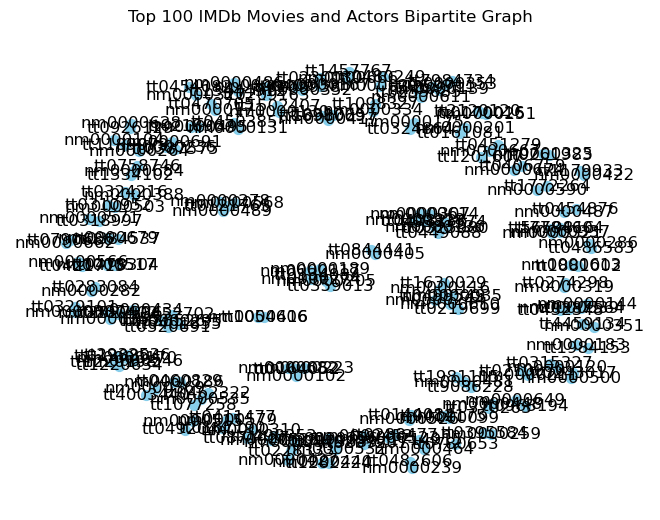

In [173]:
names_expanded = names.assign(tconst=names['knownForTitles'].str.split(',')).explode('tconst') #Take the 
actors_movies = names_expanded.merge(filtered_titles, on='tconst')

#Create Graph
B = nx.Graph()

#Filter for uniqueness (we don't need dupes)
actors = actors_movies['nconst'].unique()
movies = actors_movies['tconst'].unique()

B.add_nodes_from(actors, bipartite=0, type='actor')
B.add_nodes_from(movies, bipartite=1, type='movie')

#Add connections
edges = actors_movies[['nconst', 'tconst']].values.tolist()
B.add_edges_from(edges)

#Show basic info
print(B)

#Lets make a clean graph
sample_nodes = list(actors)[:100] + list(movies)[:100]
sample_B = B.subgraph(sample_nodes)
pos = nx.spring_layout(sample_B)
nx.draw(sample_B, pos, with_labels=True, node_size=50, node_color='skyblue', edge_color='gray')
plt.title("Top 100 IMDb Movies and Actors Bipartite Graph")
plt.show()

Okay this data is too dense to cleanly display, lets try and pear it down to something more manageable as 1116063 nodes is hard to work with quickly. Were going to select the top 250 nodes and look at the interactions between them.

Graph with 1000 nodes and 558 edges


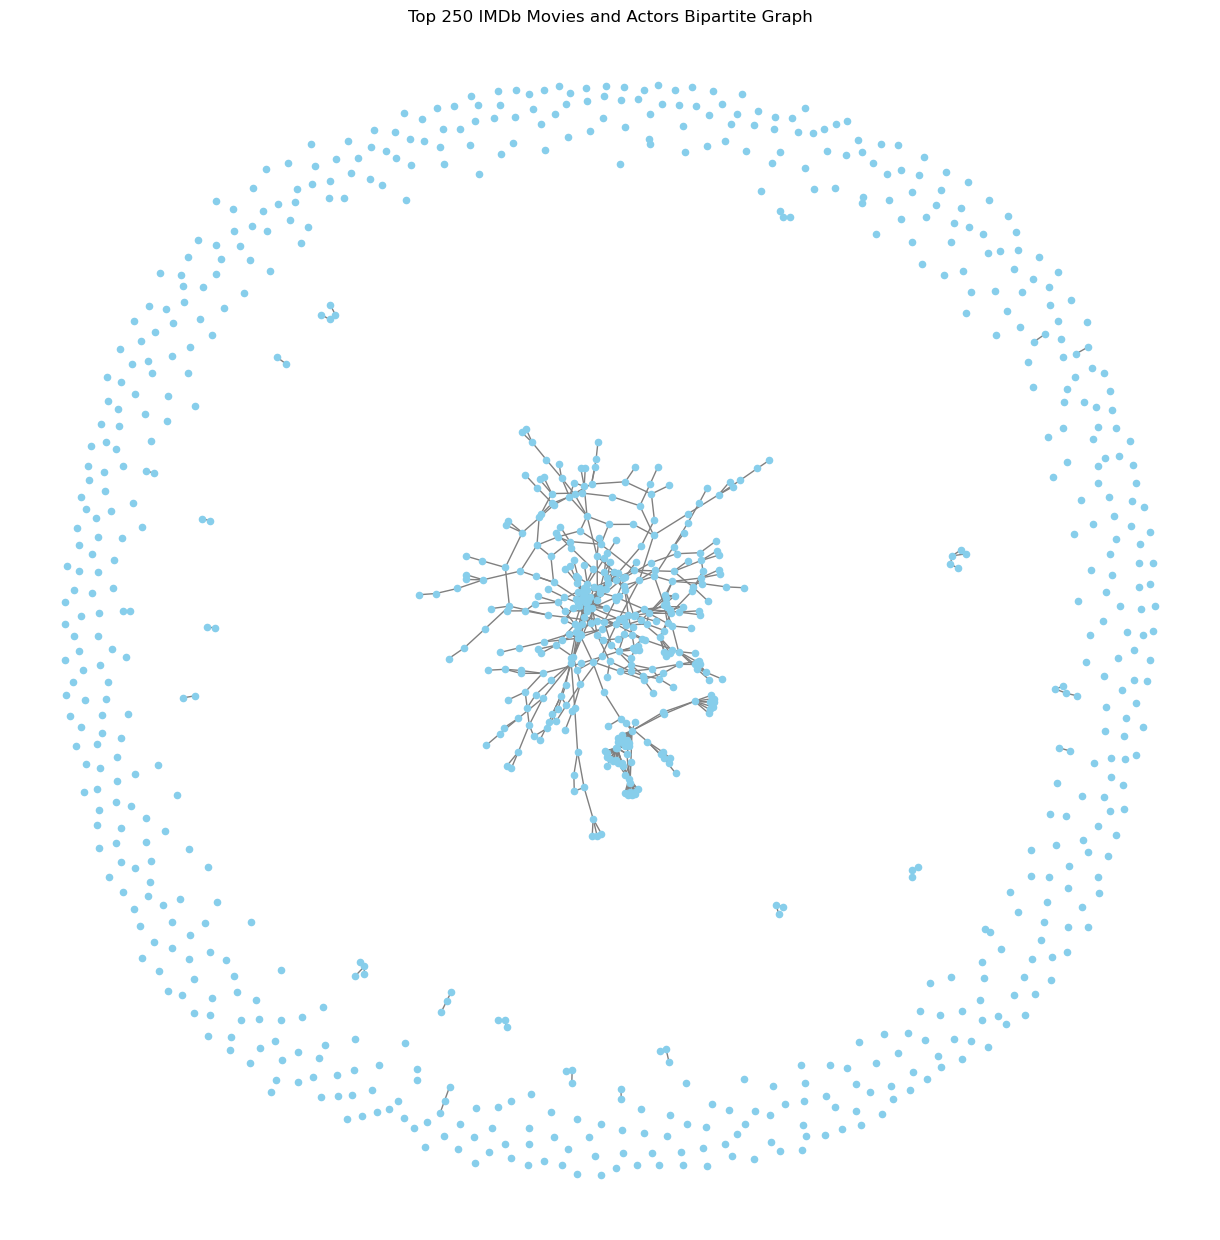

In [174]:
#Same picking mechanism tuned for 500
actor_degrees = B.degree(actors)
movie_degrees = B.degree(movies)
top_actors = [actor for actor, degree in sorted(actor_degrees, key=lambda x: x[1], reverse=True)[:500]]
top_movies = [movie for movie, degree in sorted(movie_degrees, key=lambda x: x[1], reverse=True)[:500]]

#Make Subgraph
top_nodes = top_actors + top_movies
subgraph_B = B.subgraph(top_nodes)

#Basic Metrics
print(subgraph_B)

#Quick visualisation
pos = nx.spring_layout(subgraph_B)
plt.figure(figsize=(12, 12))
nx.draw(subgraph_B, pos, with_labels=False, node_size=20, node_color='skyblue', edge_color='gray')
plt.title("Top 250 IMDb Movies and Actors Bipartite Graph")
plt.show()

Let's make sure there still some connection between movies and actors as I want to have something interesting to explore


In [175]:
#Check for connection
has_connections = any(edge[0] in top_actors and edge[1] in top_movies or edge[0] in top_movies and edge[1] in top_actors for edge in subgraph_B.edges)
print(f"Subgraph has connections between actors and movies: {has_connections}")

#Get Human Readable stuff
actor_names = names.set_index('nconst')['primaryName'].to_dict()
movie_titles = titles.set_index('tconst')['primaryTitle'].to_dict()

#Show data
print("Sample edges in the subgraph:")
for i, edge in enumerate(subgraph_B.edges(data=True)):
    if i < 10:  #Print basics
        node1, node2 = edge[:2]
        node1_label = actor_names.get(node1, movie_titles.get(node1, node1))
        node2_label = actor_names.get(node2, movie_titles.get(node2, node2))
        print(f"{node1_label} - {node2_label}")

Subgraph has connections between actors and movies: True
Sample edges in the subgraph:
Day Shift - Lanard Atkins
Day Shift - Cole Eckert
Yuka Shinada - Dark Souls III
Audrey Turcotte - Crawl
Audrey Turcotte - It Chapter Two
Audrey Turcotte - Stranger Things
Billy Doyle - Star Wars: Episode VIII - The Last Jedi
Billy Doyle - Reign of Fire
Billy Doyle - The Green Knight
Billy Doyle - The Pope's Exorcist


So we know there are still connections, how do we isolate that pretty little island of interconnectivity in the middle

Graph with 319 nodes and 424 edges


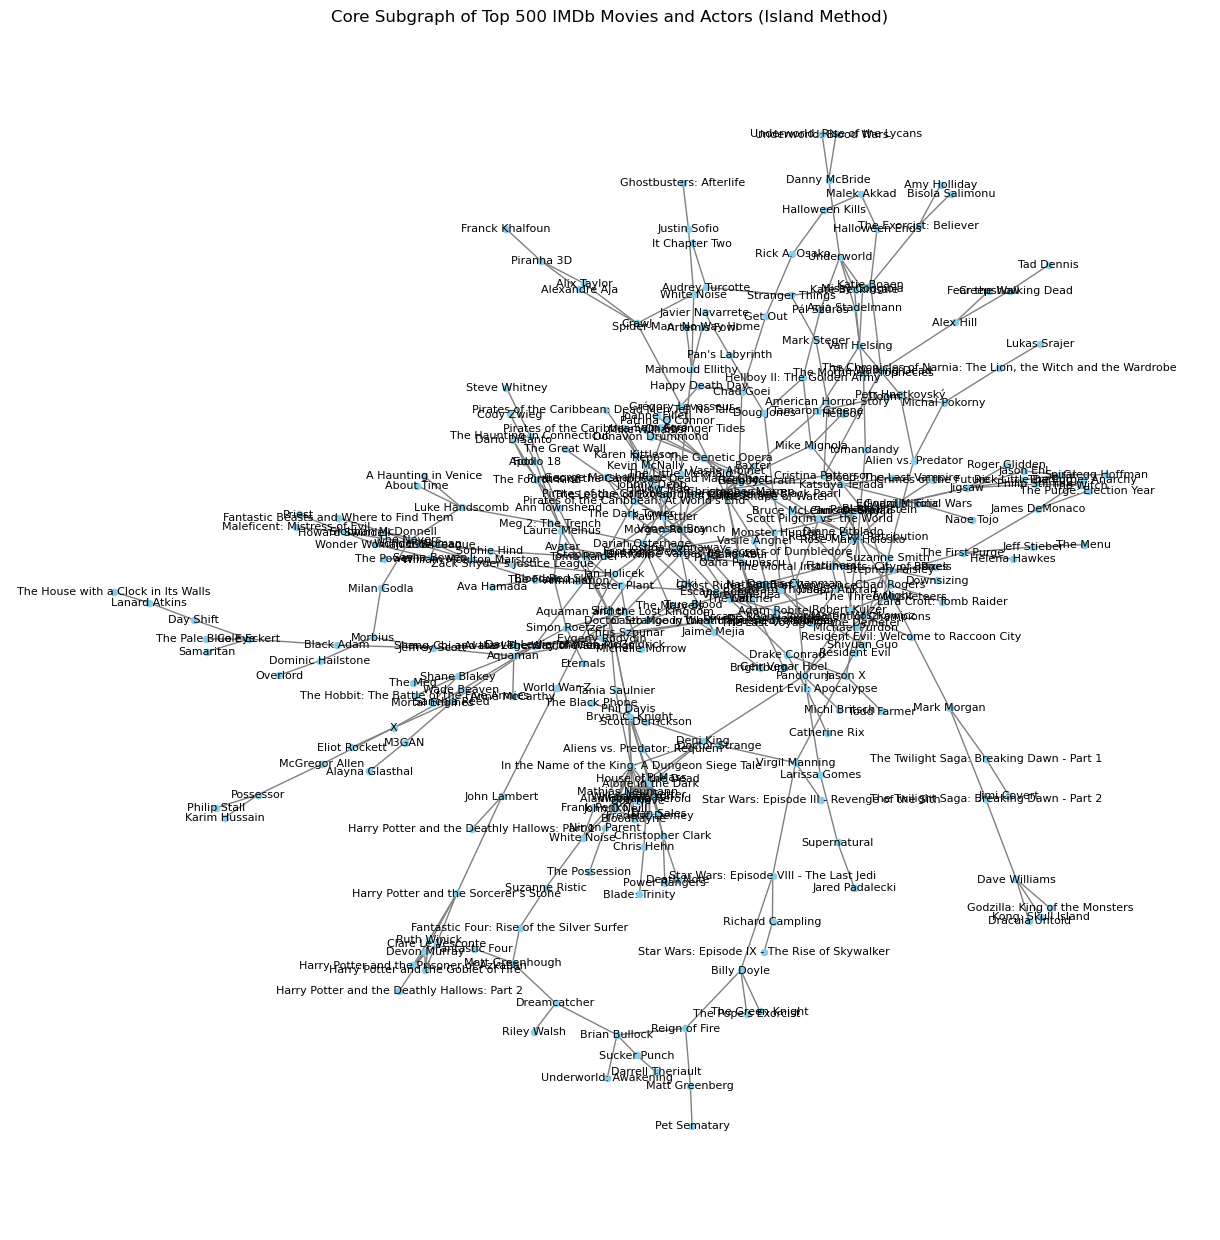

In [195]:
#Function to apply the island method
def apply_island_method(G, weight_threshold):
    G = G.copy()
    
    #Remove Edges below weight threshold
    edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w.get('weight', 1) < weight_threshold]
    G.remove_edges_from(edges_to_remove)
    
    #Keep largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    core_subgraph = G.subgraph(largest_cc).copy()
    
    return core_subgraph

#Apply the island method with a weight threshold 
core_subgraph = apply_island_method(subgraph_B, weight_threshold=1)

#Print Basic info
print(core_subgraph)

#Make object for labels that is relevent
labels = {node: actor_names.get(node, movie_titles.get(node, node)) for node in core_subgraph.nodes()}

#Visualise slimmed down data
pos = nx.spring_layout(core_subgraph)
plt.figure(figsize=(12, 12))
nx.draw(core_subgraph, pos, labels=labels, node_size=20, node_color='skyblue', edge_color='gray', font_size=8)
plt.title("Core Subgraph of Top 500 IMDb Movies and Actors (Island Method)")
plt.show()

I want to drill more into this. Let's calculate some centrality measures and see what is impactful. 

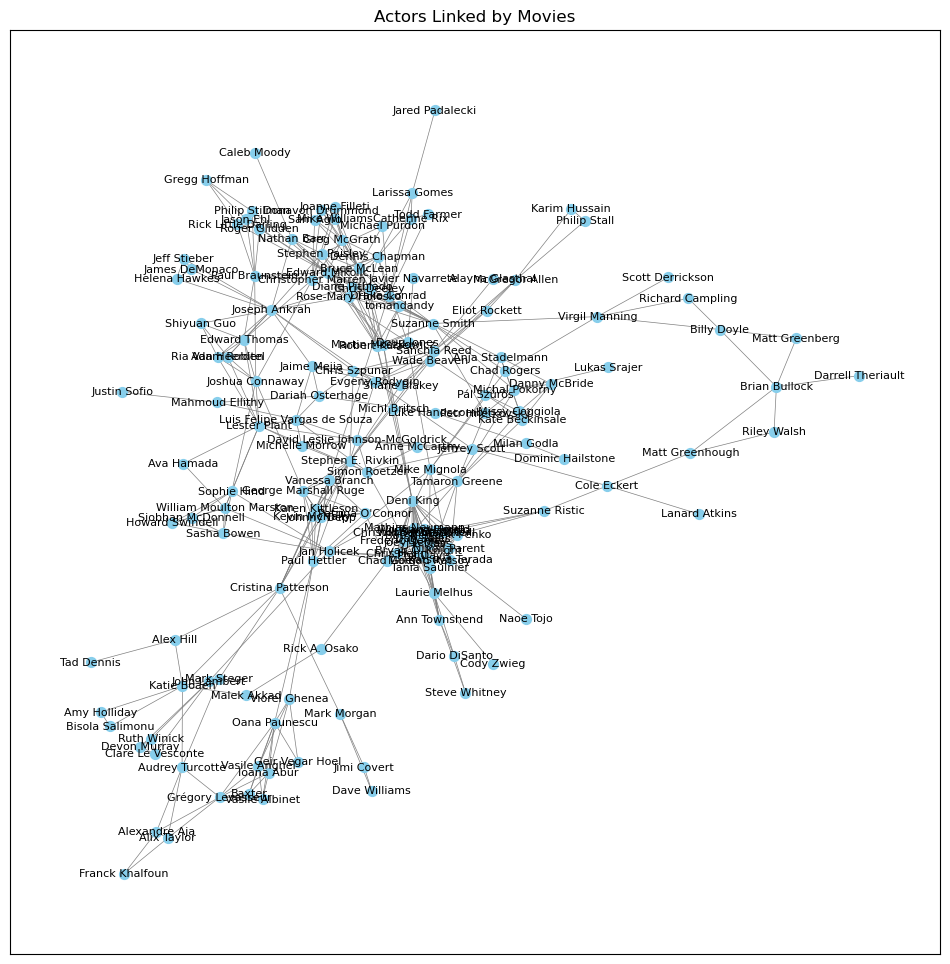

In [177]:
#ID actor and movies
actor_nodes = {node for node in core_subgraph.nodes() if node in actor_names}
movie_nodes = {node for node in core_subgraph.nodes() if node in movie_titles}

#Create actor and movie subgraphs
actor_subgraph = core_subgraph.subgraph(actor_nodes).copy()
movie_subgraph = core_subgraph.subgraph(movie_nodes).copy()

#Create bipartite for actors
actor_actor_projection = bipartite.weighted_projected_graph(core_subgraph, actor_nodes)

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(actor_actor_projection)

#Draw the nodes and edges
nx.draw_networkx_nodes(actor_actor_projection, pos, node_size=50, node_color='skyblue')
nx.draw_networkx_edges(actor_actor_projection, pos, width=0.5, edge_color='gray')

#Label
labels = {node: actor_names.get(node, node) for node in actor_actor_projection.nodes()}
nx.draw_networkx_labels(actor_actor_projection, pos, labels, font_size=8)

plt.title("Actors Linked by Movies")
plt.show()

In [119]:
# Calculate centrality measures for actor-actor projection
degree_centrality_actors = nx.degree_centrality(actor_actor_projection)
closeness_centrality_actors = nx.closeness_centrality(actor_actor_projection)
betweenness_centrality_actors = nx.betweenness_centrality(actor_actor_projection)
eigenvector_centrality_actors = nx.eigenvector_centrality(actor_actor_projection)

# Create DataFrame for actors
centrality_df_actor = pd.DataFrame({
    'Node': list(degree_centrality_actors.keys()),
    'Degree Centrality': list(degree_centrality_actors.values()),
    'Betweenness Centrality': list(betweenness_centrality_actors.values()),
    'Closeness Centrality': list(closeness_centrality_actors.values()),
    'Eigenvector Centrality': list(eigenvector_centrality_actors.values())
})

# Map the actual names to the nodes, so that we can read it
centrality_df_actor['Label'] = centrality_df_actor['Node'].map(labels)
centrality_df_actor = centrality_df_actor[['Label', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']]

# Summary statistics for actor centrality measures
print("Summary Statistics for Actor Centrality Measures:")


# Identify top nodes for each centrality measure
top_degree_centrality_actors = centrality_df_actor.nlargest(10, 'Degree Centrality')
top_betweenness_centrality_actors = centrality_df_actor.nlargest(10, 'Betweenness Centrality')
top_closeness_centrality_actors = centrality_df_actor.nlargest(10, 'Closeness Centrality')
top_eigenvector_centrality_actors = centrality_df_actor.nlargest(10, 'Eigenvector Centrality')
centrality_df_actor.describe()

Summary Statistics for Actor Centrality Measures:


,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
count,160.000000,160.000000,160.000000,1.600000e+02
mean,0.041116,0.022651,0.224559,2.851226e-02
std,0.029082,0.032732,0.035783,7.396787e-02
min,0.006289,0.000000,0.136364,5.100472e-09
25%,0.018868,0.000000,0.195572,1.973348e-05
50%,0.037736,0.006692,0.227957,2.347916e-04
75%,0.050314,0.034523,0.254910,3.502134e-03
max,0.125786,0.161678,0.287004,2.622806e-01


In [111]:
print("\nTop Actors by Degree Centrality:")
top_degree_centrality_actors


Top Actors by Degree Centrality:


,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
34,Phil Davis,0.125786,0.048650,0.261944,0.262281
49,Bryan C. Knight,0.125786,0.048650,0.261944,0.262281
95,Deni King,0.125786,0.091160,0.249608,0.256170
45,Alan Homma,0.113208,0.012808,0.229437,0.255136
17,Joey Setter,0.106918,0.000128,0.227143,0.252466
28,Will Sanderson,0.106918,0.000128,0.227143,0.252466
33,Mathias Neumann,0.106918,0.000128,0.227143,0.252466
66,Wolfgang Herold,0.106918,0.000128,0.227143,0.252466
67,John O'Neill,0.106918,0.012271,0.229107,0.242898
99,Bob Neve,0.106918,0.000128,0.227143,0.252466


In [113]:
print("\nTop Actors by Betweenness Centrality:")
top_betweenness_centrality_actors



Top Actors by Betweenness Centrality:


,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
60,Joseph Ankrah,0.088050,0.161678,0.285971,0.000795
108,Chad Goei,0.044025,0.146767,0.274611,0.004792
79,Morgan Ratsoy,0.062893,0.130390,0.274611,0.054768
104,Paul Hettler,0.056604,0.109715,0.261513,0.000033
25,Stephen E. Rivkin,0.075472,0.107880,0.260229,0.000026
50,Cristina Patterson,0.056604,0.105308,0.233824,0.000010
22,Patrina O'Connor,0.037736,0.102934,0.269949,0.000319
95,Deni King,0.125786,0.091160,0.249608,0.256170
90,Evgeny Rodygin,0.050314,0.090896,0.269492,0.000083
57,Joshua Connaway,0.050314,0.088451,0.285458,0.000160


In [115]:
print("\nTop Actors by Closeness Centrality:")
top_closeness_centrality_actors


Top Actors by Closeness Centrality:


,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
88,Diane Pitblado,0.081761,0.069404,0.287004,0.004927
60,Joseph Ankrah,0.088050,0.161678,0.285971,0.000795
57,Joshua Connaway,0.050314,0.088451,0.285458,0.000160
35,Rose-Mary Holosko,0.069182,0.051115,0.281915,0.004744
10,Christopher Marren,0.069182,0.049145,0.280423,0.000755
31,Dennis Chapman,0.062893,0.059952,0.278947,0.001465
12,Mike Mignola,0.050314,0.068049,0.277487,0.004847
140,Bruce McLean,0.106918,0.050106,0.277487,0.005046
128,Edward Mikolic,0.094340,0.047694,0.276522,0.004904
79,Morgan Ratsoy,0.062893,0.130390,0.274611,0.054768


In [117]:
print("\nTop Actors by Eigenvector Centrality:")
top_eigenvector_centrality_actors


Top Actors by Eigenvector Centrality:


,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
34,Phil Davis,0.125786,0.048650,0.261944,0.262281
49,Bryan C. Knight,0.125786,0.048650,0.261944,0.262281
95,Deni King,0.125786,0.091160,0.249608,0.256170
45,Alan Homma,0.113208,0.012808,0.229437,0.255136
17,Joey Setter,0.106918,0.000128,0.227143,0.252466
28,Will Sanderson,0.106918,0.000128,0.227143,0.252466
33,Mathias Neumann,0.106918,0.000128,0.227143,0.252466
66,Wolfgang Herold,0.106918,0.000128,0.227143,0.252466
99,Bob Neve,0.106918,0.000128,0.227143,0.252466
67,John O'Neill,0.106918,0.012271,0.229107,0.242898


It's interesting to see the sheer volume of actors I don't really recognize! Most of these people appear to be in more background roles in the movies, with Phil Davis alone having more than 160 credits to his name. I think its rather interesting to see the network created by looking at these often overlooked actors 

Now lets do the same for movies:

In [197]:
movie_movie_projection = bipartite.weighted_projected_graph(core_subgraph, movie_nodes)

# Calculate centrality measures for movie-movie projection
degree_centrality_movies = nx.degree_centrality(movie_movie_projection)
closeness_centrality_movies = nx.closeness_centrality(movie_movie_projection)
betweenness_centrality_movies = nx.betweenness_centrality(movie_movie_projection)
#Bump up iterations and tollerence
try:
    eigenvector_centrality_movies = nx.eigenvector_centrality(movie_movie_projection, max_iter=1000, tol=1e-06)
except nx.PowerIterationFailedConvergence:
    print("Eigenvector centrality did not converge, trying higher max_iter and lower tol.")
    eigenvector_centrality_movies = nx.eigenvector_centrality(movie_movie_projection, max_iter=5000, tol=1e-04)


centrality_df_movies = pd.DataFrame({
    'Node': list(degree_centrality_movies.keys()),
    'Degree Centrality': list(degree_centrality_movies.values()),
    'Betweenness Centrality': list(betweenness_centrality_movies.values()),
    'Closeness Centrality': list(closeness_centrality_movies.values()),
    'Eigenvector Centrality': list(eigenvector_centrality_movies.values())
})

#make it human readable
centrality_df_movies['Label'] = centrality_df_movies['Node'].map(labels)
centrality_df_movies = centrality_df_movies[['Label', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']]

# Summary stats
print("Summary Statistics for Movie Centrality Measures:")


#Pluck top nodes
top_degree_centrality_movies = centrality_df_movies.nlargest(10, 'Degree Centrality')
top_betweenness_centrality_movies = centrality_df_movies.nlargest(10, 'Betweenness Centrality')
top_closeness_centrality_movies = centrality_df_movies.nlargest(10, 'Closeness Centrality')
top_eigenvector_centrality_movies = centrality_df_movies.nlargest(10, 'Eigenvector Centrality')
centrality_df_movies.describe()

Summary Statistics for Movie Centrality Measures:


,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
count,159.000000,159.000000,159.000000,159.000000
mean,0.027625,0.024460,0.212110,0.056227
std,0.016462,0.041964,0.033542,0.056103
min,0.006329,0.000000,0.141577,0.000689
25%,0.018987,0.000000,0.188322,0.011733
50%,0.018987,0.000000,0.211230,0.038946
75%,0.037975,0.034956,0.237594,0.082845
max,0.094937,0.271524,0.284173,0.241207


In [199]:
top_degree_centrality_movies


,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
36,Hellboy,0.094937,0.271524,0.284173,0.190789
39,Resident Evil: Retribution,0.082278,0.176636,0.267797,0.230332
32,Slither,0.075949,0.165747,0.266442,0.241207
9,Avatar: The Way of Water,0.069620,0.163447,0.261157,0.092402
69,Flatliners,0.063291,0.133972,0.270085,0.166394
77,House of the Dead,0.063291,0.047685,0.237952,0.226539
97,Pirates of the Caribbean: The Curse of the Bla...,0.063291,0.154486,0.253205,0.088312
124,Pirates of the Caribbean: At World's End,0.063291,0.073718,0.257329,0.105604
45,Scott Pilgrim vs. the World,0.056962,0.033561,0.262458,0.172542
52,Aquaman and the Lost Kingdom,0.056962,0.090812,0.252800,0.139812


In [203]:
top_betweenness_centrality_movies

,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
36,Hellboy,0.094937,0.271524,0.284173,0.190789
39,Resident Evil: Retribution,0.082278,0.176636,0.267797,0.230332
32,Slither,0.075949,0.165747,0.266442,0.241207
9,Avatar: The Way of Water,0.069620,0.163447,0.261157,0.092402
97,Pirates of the Caribbean: The Curse of the Bla...,0.063291,0.154486,0.253205,0.088312
35,Resident Evil,0.050633,0.137455,0.245723,0.093878
69,Flatliners,0.063291,0.133972,0.270085,0.166394
3,Doctor Strange in the Multiverse of Madness,0.050633,0.129676,0.271945,0.106430
87,Pirates of the Caribbean: Dead Man's Chest,0.050633,0.116982,0.265546,0.088361
157,Happy Death Day,0.018987,0.092190,0.257329,0.050473


In [205]:
top_closeness_centrality_movies

,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
36,Hellboy,0.094937,0.271524,0.284173,0.190789
142,Tomb Raider,0.050633,0.075852,0.272884,0.185775
3,Doctor Strange in the Multiverse of Madness,0.050633,0.129676,0.271945,0.106430
28,Monster Hunter,0.050633,0.059841,0.270085,0.150108
69,Flatliners,0.063291,0.133972,0.270085,0.166394
39,Resident Evil: Retribution,0.082278,0.176636,0.267797,0.230332
32,Slither,0.075949,0.165747,0.266442,0.241207
87,Pirates of the Caribbean: Dead Man's Chest,0.050633,0.116982,0.265546,0.088361
108,Escape Room,0.044304,0.028222,0.265546,0.144945
45,Scott Pilgrim vs. the World,0.056962,0.033561,0.262458,0.172542


In [207]:
top_eigenvector_centrality_movies 

,Label,Degree Centrality,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality
32,Slither,0.075949,0.165747,0.266442,0.241207
39,Resident Evil: Retribution,0.082278,0.176636,0.267797,0.230332
77,House of the Dead,0.063291,0.047685,0.237952,0.226539
72,Alone in the Dark,0.056962,0.035027,0.237594,0.221631
33,In the Name of the King: A Dungeon Siege Tale,0.050633,0.035269,0.237237,0.202952
36,Hellboy,0.094937,0.271524,0.284173,0.190789
142,Tomb Raider,0.050633,0.075852,0.272884,0.185775
68,Zack Snyder's Justice League,0.056962,0.080407,0.260297,0.181393
45,Scott Pilgrim vs. the World,0.056962,0.033561,0.262458,0.172542
146,Pandorum,0.037975,0.047370,0.231332,0.168946


Wow its amazing to see the titles that are high on this list! I think Hellboy is a great exammple of a not so popular move, that has a high degree of connectivity to every other movie.

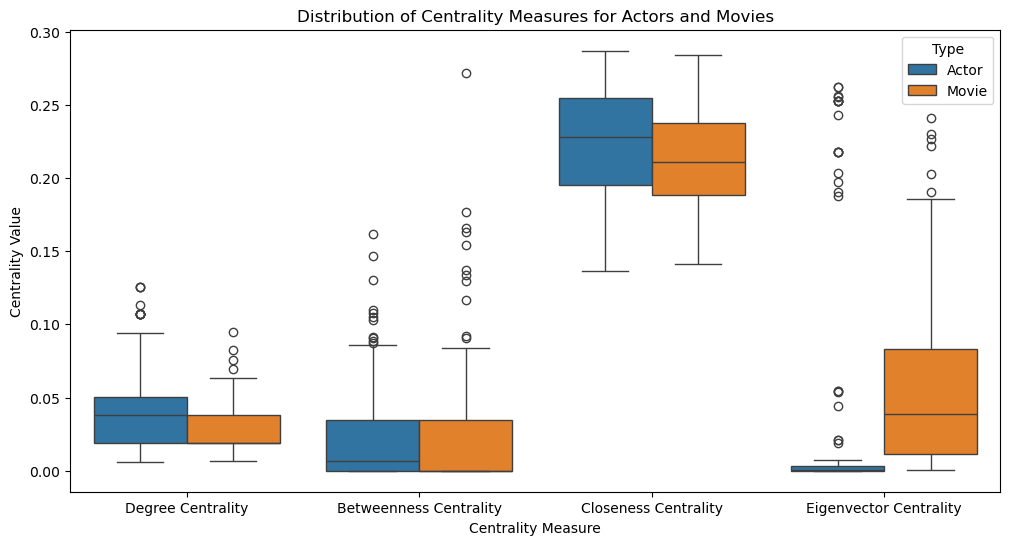

In [158]:
centrality_df_actor['Type'] = 'Actor'
centrality_df_movies['Type'] = 'Movie'
centrality_df_movies = centrality_df_movies[['Label', 'Type', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']]
centrality_df_actor = centrality_df_actor[['Label', 'Type', 'Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']]
centrality_df_combined = pd.concat([centrality_df_actor, centrality_df_movies])
plt.figure(figsize=(12, 6))
sns.boxplot(data=centrality_df_combined.melt(id_vars=['Label', 'Type'], value_vars=['Degree Centrality', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality']),
            x='variable', y='value', hue='Type')
plt.title("Distribution of Centrality Measures for Actors and Movies")
plt.xlabel('Centrality Measure')
plt.ylabel('Centrality Value')
plt.legend(title='Type')
plt.show()

The centrality measures for actors indicate that while most actors have similar and relatively low centrality values, a few actors stand out with higher centrality, serving as important connectors or influential nodes within the network. Movies appear to suffer from the same issue, although their eigenvector centrality has a higher avereage, with a much larger spread. 